# The final solution evaluation and vizualization

This notebook is focused on comparing the solution approaches I used to solve the text detoxification task. The previous notebooks (2.0-2.2) contain the training phase and inference for each of the approaches. The goal of this notebook is to plot the results and compute metrics on a test set consisting of 5000 text examples.

In [ ]:
%cd ..
from src.visualization import visualize
from src.data.evaluate import evaluate_on_test
import pandas as pd

## Training 

### Baseline solution

The training was not reqiured for this approach.

### Pytorch transformer

The training was performed on 10 epochs with batch size 32. Let's plot the training and validation losses:

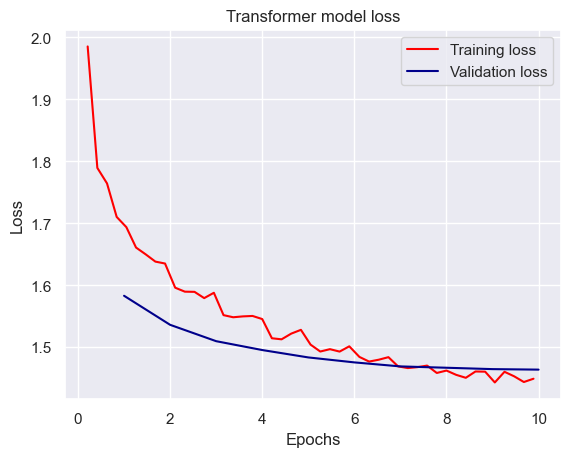

In [3]:
visualize.plot_losses('transformer')

### T5 model fine-tuned

The training was performed on 10 epochs with batch size of 16 (the bigger size of batch caused the GPU out of memory limit). Let's plot the training and validation results:

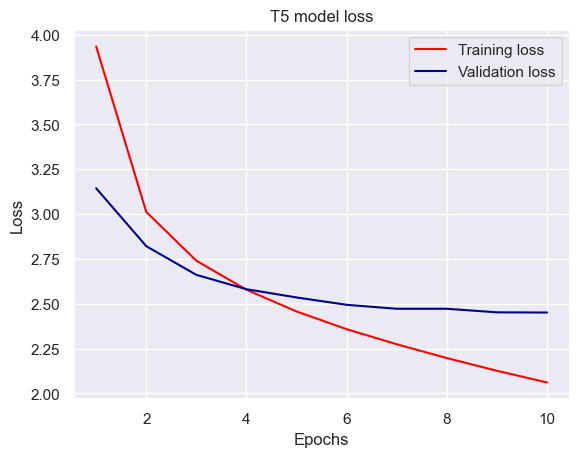

In [4]:
visualize.plot_losses('t5')

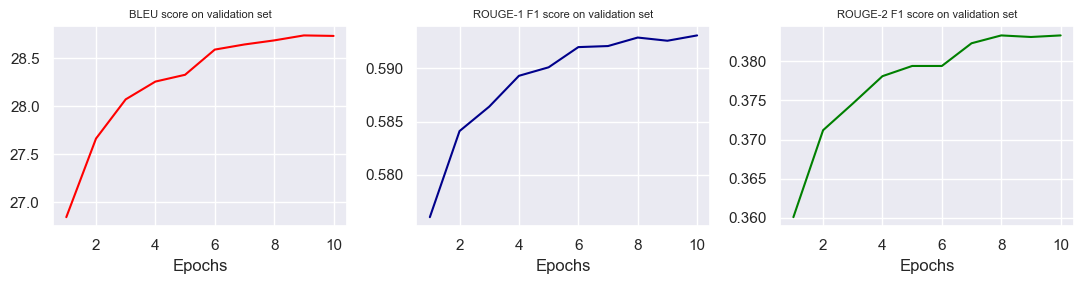

In [5]:
visualize.plot_eval_metrics()

## Evaluation on test set

Metrics used:

- **BLEU-2** and **BLEU-4**: These metrics are useful for assessing the quality of generated text. They measure how closely the generated text matches the reference text in terms of 2-grams (pairs of adjacent words) and 4-grams, respectively. 

- **ROUGE-1** and **ROUGE-2**: These metrics are used to evaluate the quality of texts by comparing them to reference texts. They measure the overlap of unigrams and bigrams between the generated text and the reference text. This can be useful in this task to ensure that the generated text maintains the same meaning as the original text. For these metrics, I used f1 measure since it is combination of the both recall and precision.

- **Toxicity score** and **toxicity ratio**: These metrics measure the toxicity score values and a proportion of toxic comments in the generated text respectively, using a pretrained hate speech classification model `roberta-hate-speech-dynabench-r4` ([link to the toxicity metric](https://huggingface.co/spaces/evaluate-measurement/toxicity)). The goal of a text detoxification task is to reduce these metrics as much as possible, while maintaining the meaning and quality of the text.

In [6]:
import evaluate
toxicity = evaluate.load("toxicity", module_type="measurement")

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


Let's firstly compute toxicity ratios for source and target texts from the test set:

In [7]:
test_df = pd.read_csv("./data/interim/test.csv")

reference_results = toxicity.compute(predictions=test_df['reference'].to_list(), aggregation="ratio")
detox_reference_results = toxicity.compute(predictions=test_df['detox_reference'].to_list(), aggregation="ratio")

print('Toxicity ratio in source text:', reference_results['toxicity_ratio'])
print('Toxicity ratio in detoxified (target) text:', detox_reference_results['toxicity_ratio'])

Toxicity ratio in source text: 0.1694
Toxicity ratio in detoxified (target) text: 0.0618


### Baseline solution

Average metrics:
BLEU-2 : 0.3129
BLEU-4 : 0.1148
rouge1_fmeasure : 0.5578
rouge2_fmeasure : 0.3063
Toxicity ratio : 0.1182


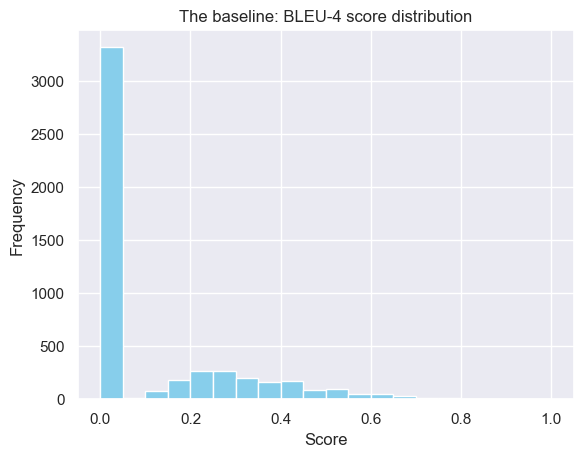

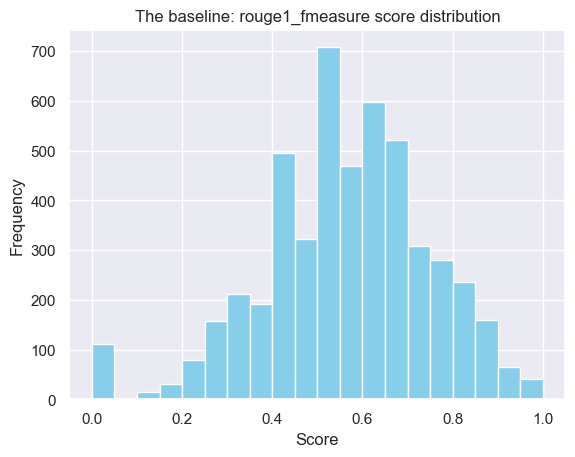

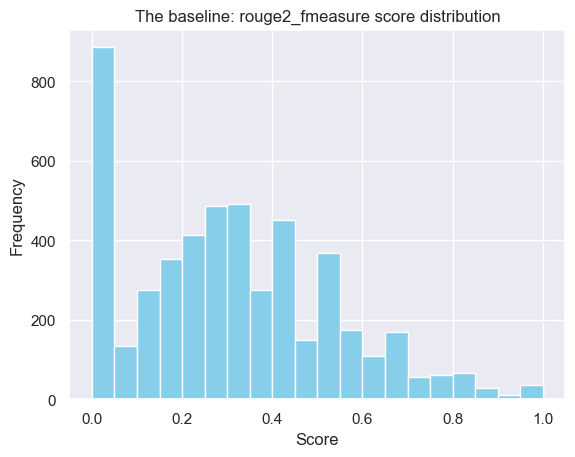

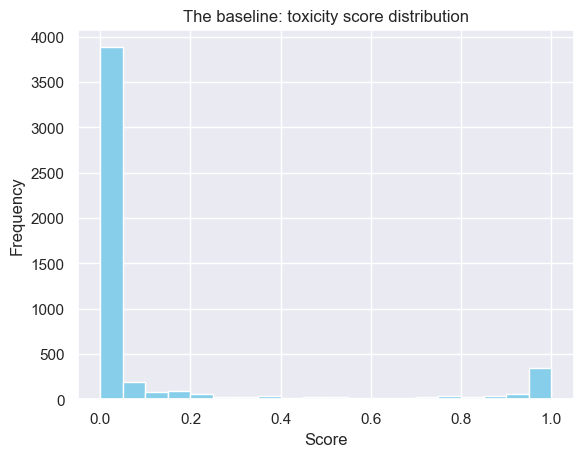

In [8]:
evaluate_on_test(approach_type='baseline', toxicity=toxicity)

### Pytorch transformer

Average metrics:
BLEU-2 : 0.3443
BLEU-4 : 0.1499
rouge1_fmeasure : 0.5656
rouge2_fmeasure : 0.3469
Toxicity ratio : 0.089


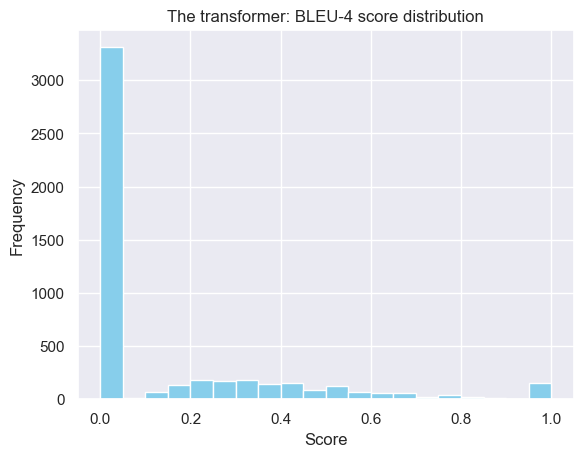

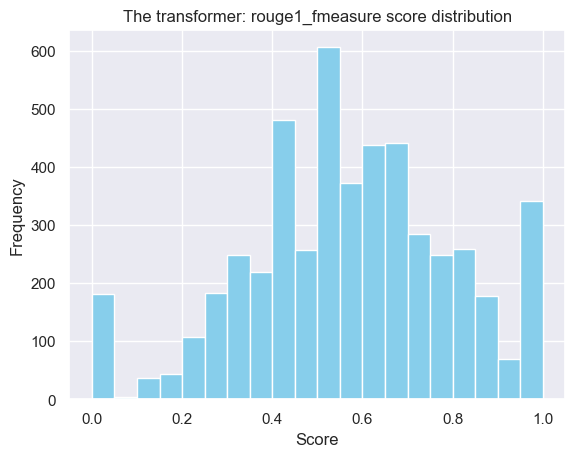

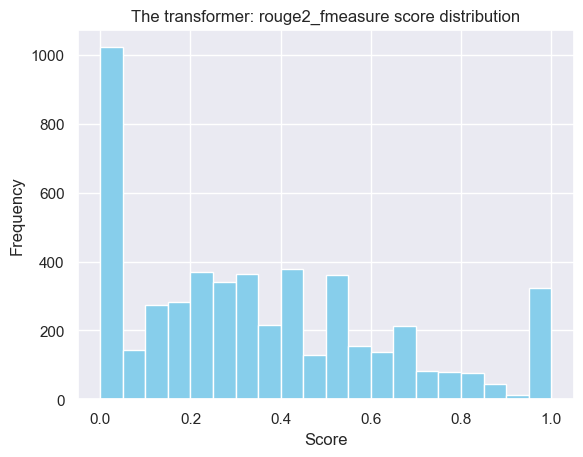

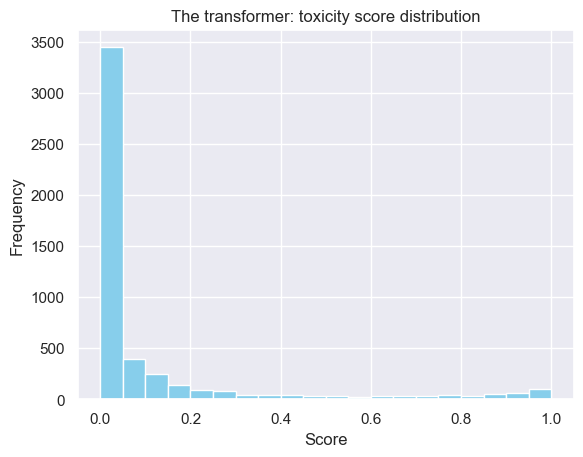

In [9]:
evaluate_on_test(approach_type='transformer', toxicity=toxicity)

### T5 model fine-tuned

Average metrics:
BLEU-2 : 0.4236
BLEU-4 : 0.2119
rouge1_fmeasure : 0.5982
rouge2_fmeasure : 0.3921
Toxicity ratio : 0.0592


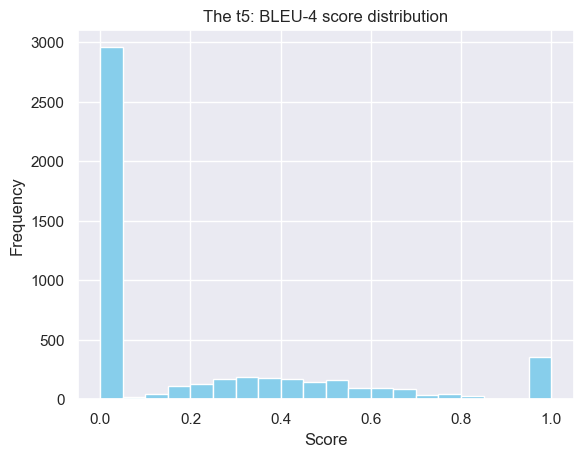

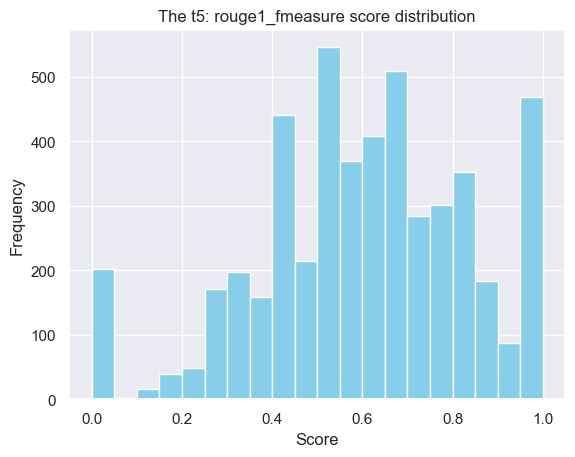

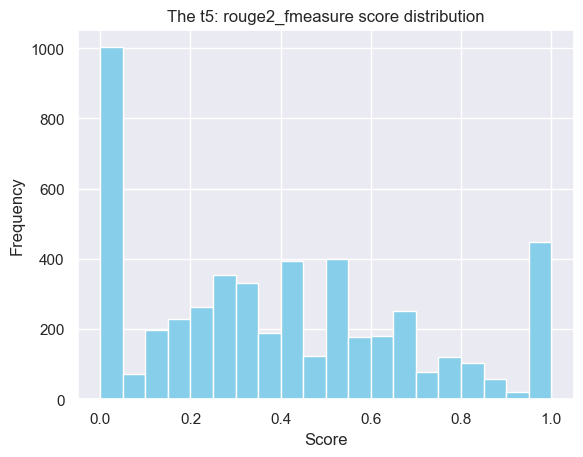

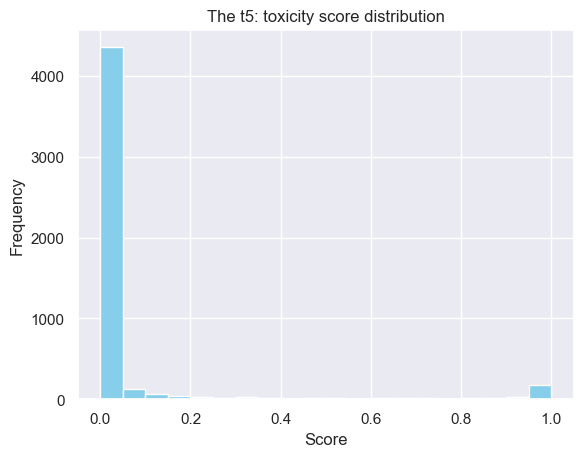

In [10]:
evaluate_on_test(approach_type='t5', toxicity=toxicity)

As can be seen from the plot for t5 model toxicity score distribution, the t5 model performs quite well. The majority of the sentences has toxicity scores < 0.05. 

### Results:

After the evaluation on test set, the following results are obtained:

|                     | BLEU-2 | BLEU-4 | ROUGE-1 F1 | ROUGE-2 F1 | Toxicity ratio |
|---------------------|--------|--------|------------|------------|----------------|
| Baseline            | 0.3129 | 0.1148 | 0.5578     | 0.3063     | 0.1182         |
| Pytorch transformer | 0.3443 | 0.1499 | 0.5656     | 0.3469     | 0.089          |
| **T5-base fine-tuned**  | **0.4236** | **0.2119** | **0.5982**     | **0.3921**     | **0.0592**         |

As can be seen, the last approach (fine-tuning the t5 model) demonstrates the highest metrics. Moreover, it should be mentioned, for t5 the toxicity ratio metric is **0.0592** while the target detoxified sentences metric stands at **0.0618**. Therefore, this approach delivers effective results. On the other hand, both the baseline method and the PyTorch transformer yield satisfactory results. The baseline method reduces the toxicity ratio from **0.1694** (source) to **0.1182**, while the pythorch transformer decreases the source toxicity ratio twice, effectively lowering the toxicity in the original texts. 

However, due to limitations in computational resources (specifically, the absence of a GPU on my laptop, I used the Colab and Kaggle, but the training time was huge), I trained models for a relatively small number of epochs (10). Increasing the number of epochs would likely provide even better performance. 